In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


# Whole globe tries

In [2]:
from windspharm.xarray import VectorWind

In [3]:
ds = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/tmp/uvfull/195901.nc").rename(level="lev").isel(lon=slice(None, None, 2), lat=slice(None, None, 2))
ds["s"] = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)
ds = flatten_by(ds, "s")

In [4]:
w = VectorWind(ds["u"].fillna(0), ds["v"].fillna(0))

In [5]:
ds["u_smo"] = w.truncate(w.u(), truncation=63)
ds["v_smo"] = w.truncate(w.v(), truncation=63)
ds["s_smo"] = np.sqrt(ds["u_smo"] ** 2 + ds["v_smo"] ** 2)

In [6]:
sigmas=range(3, 6)
if "time" in ds.dims:
    filtered = np.zeros_like(ds["s_smo"])
    for t in trange(len(filtered)):
        da = ds["s_smo"][t]
        filtered[t, :, :] = sato(da / da.max(), black_ridges=False, sigmas=sigmas)
        filtered[t] = filtered[t] / filtered[t].max()
ds["criterion"] = ds["s_smo"] * filtered

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:04<00:00, 26.29it/s]


In [14]:
groups, dist_mats = cluster_criterion(ds.isel(time=0), criterion_threshold=10)

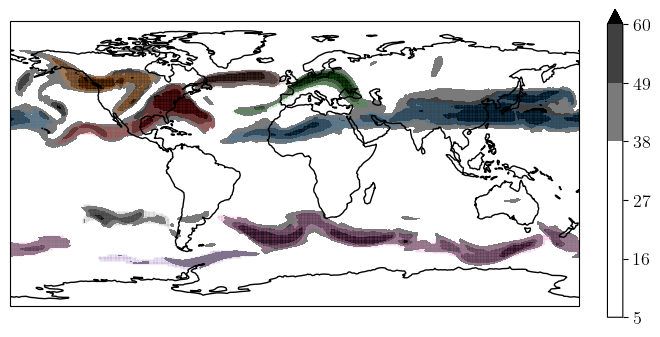

In [15]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds.isel(time=0)["s"]], transparify=3, nlevels=6, cmap="Greys", q=0.96)
ax = clu.axes[0]
for group in groups:
    ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=1, alpha=0.11)

In [41]:
jets = jets_from_mask(groups, dist_mats)

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_weighted[istart, ends] ** 0.5
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/jet_finding.py:653: RuntimeWarning: divide by zero encountered in divide
  dmat_unweighted[istart, ends] ** 4 / dmat_

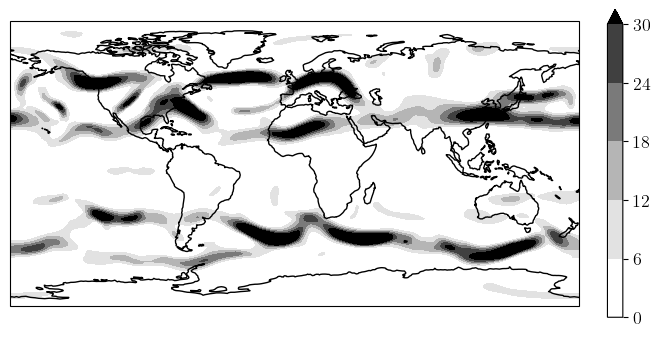

In [46]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds.isel(time=0)["criterion"]], transparify=1, nlevels=6, cmap="Greys", q=0.96)
ax = clu.axes[0]
# for jet in jets:
#     ax.scatter(*jet[["lon", "lat"]].to_numpy().T, lw=2, alpha=0.5)

 19%|█▉        | 12/64 [11:36<50:16, 58.00s/it]


KeyboardInterrupt: 

In [50]:
year, month

(1971, 7)

# SCAFET tests

In [2]:
import scafet.object_properties as obp
import scafet.ridge_detection as rd
import scafet.object_filtering as obf
import scafet.object_tracking as obt

In [3]:
grid_area = xr.open_dataset(f"{DATADIR}/ERA5/grid_info/grid_area_era5.nc")
# .sel(latitude=latslice,longitude=lonslice)
grid_area = grid_area.rename({"longitude": "lon"})
grid_area = grid_area.rename({"latitude": "lat"})
grid_area = grid_area.reindex(lat=list(reversed(grid_area.lat)))
grid_area = grid_area.isel(lon=slice(None, None, 4), lat=slice(None, None, 4))
grid_area = grid_area.assign_coords(lon=((grid_area.lon + 180) % 360) - 180)
grid_area = grid_area.roll(lon=len(grid_area.lon) // 2, roll_coords=True)

land_mask = xr.open_dataset(f"{DATADIR}/ERA5/grid_info/land_sea_mask_era5.nc")
land_mask = land_mask.isel(lon=slice(None, None, 4), lat=slice(None, None, 4))
land_mask = land_mask.assign_coords(lon=((land_mask.lon + 180) % 360) - 180)
land_mask = land_mask.roll(lon=len(land_mask.lon) // 2, roll_coords=True)

In [4]:
data = xr.open_dataset(f"{DATADIR}/ERA5/tmp/uvfull/195901.nc").isel(lon=slice(None, None, 2), lat=slice(None, None, 2)).rename(level="lev")
data["mag"] = np.sqrt(data["u"] ** 2 + data["v"] ** 2)

In [5]:
smooth_scale = 6e3
angle_threshold = 45
shape_index = [0.375, 1]
min_length = 5e3
min_volume = 1e6
min_height = 50
shape_eccentricity = [0.0, 1.0]
lat_mask = [-90, 90]
lon_mask = [-180, 180]

properties = obp.object_properties3D(
    data,
    grid_area,
    [],
    [],
    [],
    land_mask,
    min_length,
    min_height,
    min_volume,
    smooth_scale,
    None,
    None,
    shape_index,
    lon_mask,
    lat_mask,
)

In [6]:
with Timer():
    rdetect = rd.RidgeDetector(data[["mag"]])
    data_smo = rdetect.apply_smoother(data[["mag"]], properties)

Elapsed time: 11.1014 seconds


In [7]:
ridges = rdetect.apply_ridge_detection(data_smo[["mag"]].isel(time=slice(10)), properties)

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/pint/facets/plain/quantity.py:760: RuntimeWarning: invalid value encountered in subtract
  magnitude = op(self._magnitude, other._magnitude)


In [27]:
obfilter = obf.filterObjects(ridges)
filtered = obfilter.apply_filter(
    ridges.isel(time=slice(2)),
    data[["mag"]].isel(time=slice(2)),
    ["max_intensity"],
    [20],
    properties,
    "ridges",
)

In [32]:
np.histogram(c)

(array([      0,       0,       0,       0,       0, 2085120,       0,
              0,       0,       0]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]))

# plev, v6

Elapsed time: 0.0238 seconds


100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Text(0.5, 0.98, '28-07-1999T06:00')

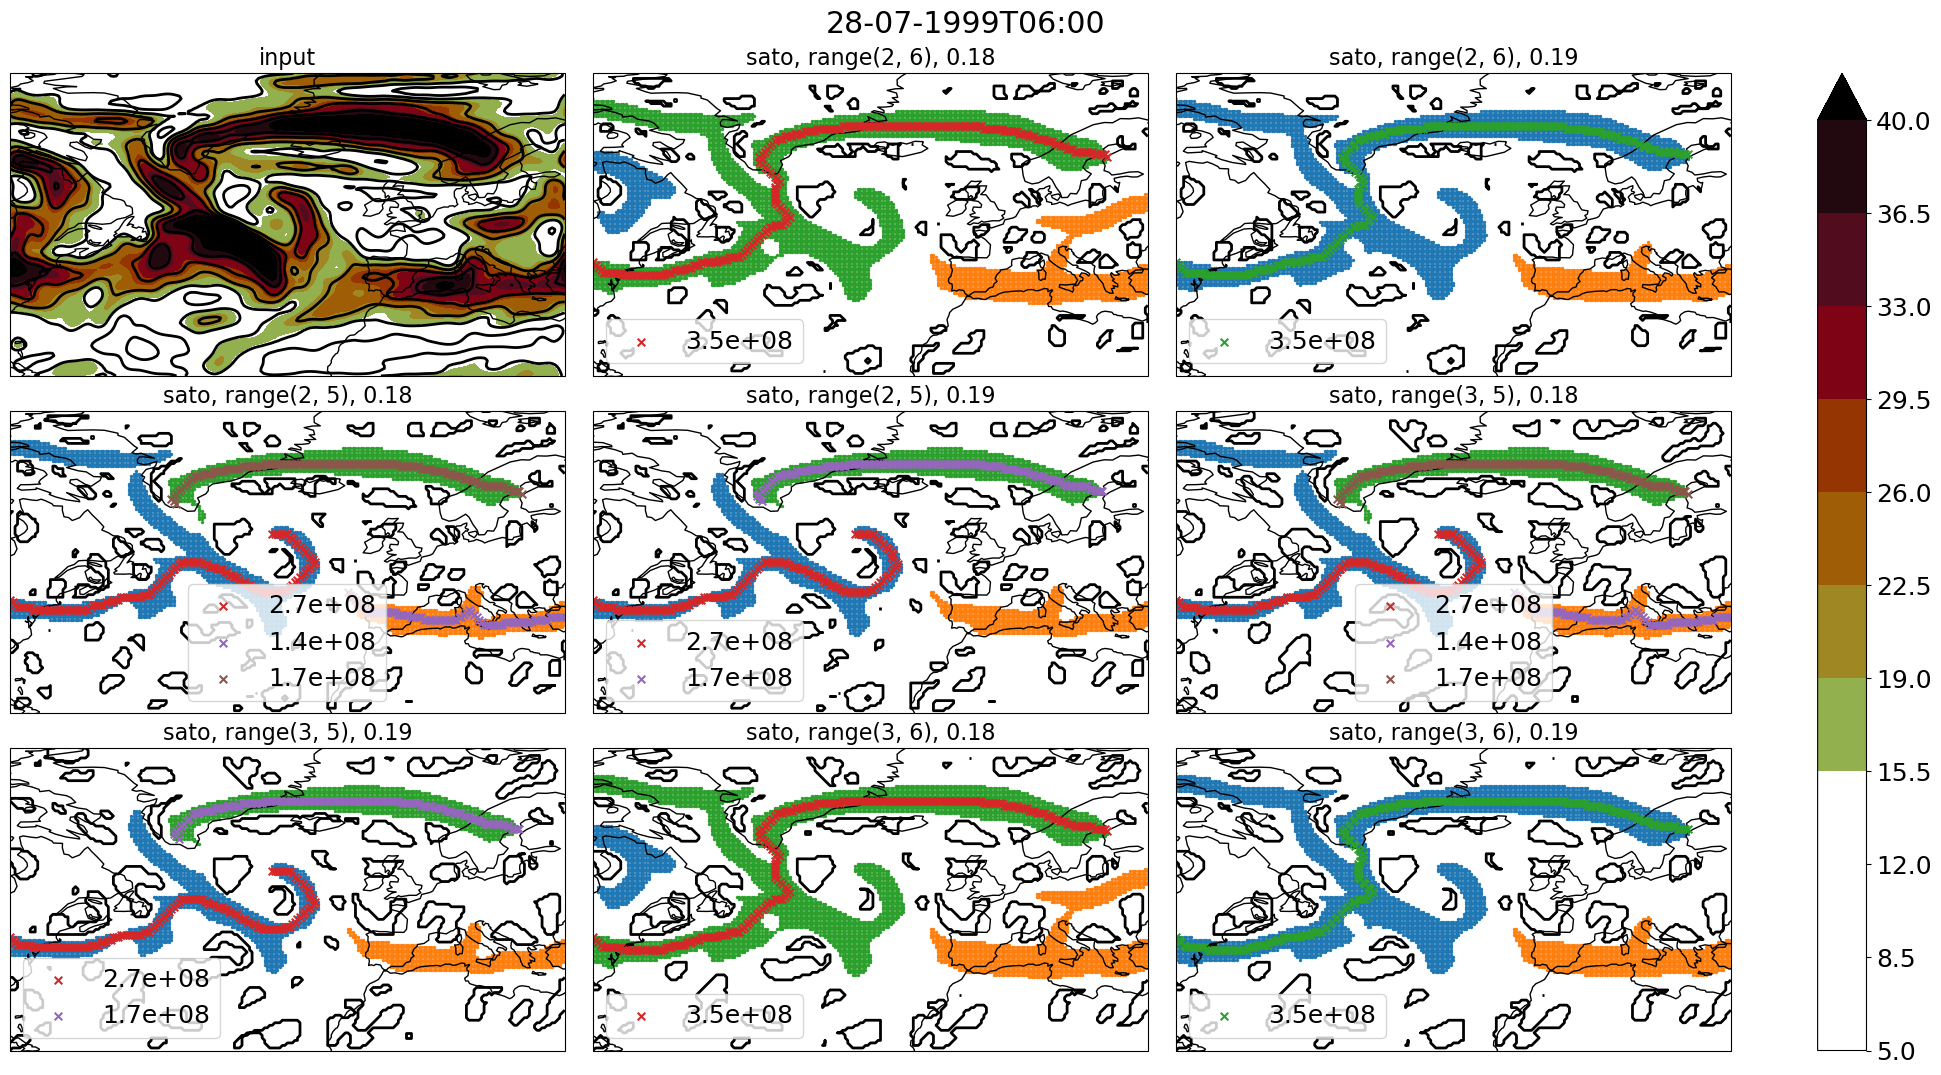

In [41]:
from skimage.filters import meijering, sato, frangi, hessian
clu = Clusterplot(3, 3, get_region(ds))
# it = np.random.randint(0, ds.time.shape[0])
# q = qss.loc[0.6, ds.time[it].dt.dayofyear.item()].item()
ds_ = ds.isel(time=it)
ds_ = flatten_by(ds_, "s")
with Timer():
    ds_["s_smo"] = smooth(ds_["s"], smooth_map={"lon+lat": ("fft", 0.25)})
titles = ["input"]
to_plot = [ds_["s_smo"]]
for ax, (filter_, sigmas, threshold) in tqdm(zip(clu.axes.ravel()[1:], product([sato], [range(2, 6), range(2, 5), range(3, 5), range(3, 6)], [0.18, 0.19])), total=8):
    fname = filter_.__name__
    black_ridges = fname == "hessian"
    multiply = fname == "sato"
    thisds = ds_.copy()
    thisds["s_smo"] = (("lat", "lon"), filter_(thisds["s_smo"] / thisds["s_smo"].max(), black_ridges=black_ridges, sigmas=sigmas) * (4 if multiply else 1))
    # thisds["s_smo"] = thisds["s"] / thisds["s"].max() * filter_(thisds["s"] / thisds["s"].max(), black_ridges=black_ridges, sigmas=sigmas, mode="constant", cval=0)
    to_plot.append(thisds["s_smo"])
    titles.append(f"{fname}, {sigmas}, {threshold:.2f}")
    groups, dist_mats = cluster_wind_speed(thisds, criterion_threshold=threshold, distance_function=pairwise_distances, min_size=500, distance_threshold=1.5)
    for group, dist_mat in zip(groups, dist_mats):
        ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=2)
    jets = []
    for group, dist_mat in zip(groups, dist_mats):
        masked_weights = compute_weights(group, dist_mat)
        graph = csgraph_from_masked(masked_weights)
        jet = find_jets_in_group_v2(graph, group, dist_mat, 1.4e8)
        if jet is not None:
            jets.append(jet)
    for jet in jets:
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker="x", s=30, label=f"{jet_integral_haversine(jet[['lon', 'lat', 's']].to_numpy()):.1e}", zorder=2)
    ax.legend()
clu.add_contourf([to_plot[0]], transparify=3, nlevels=11, q=0.95, zorder=0)
_ = clu.add_contour(to_plot, titles=titles, zorder=1)
clu.fig.suptitle(ds.time[it].dt.strftime("%d-%m-%YT%H:00").item())

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


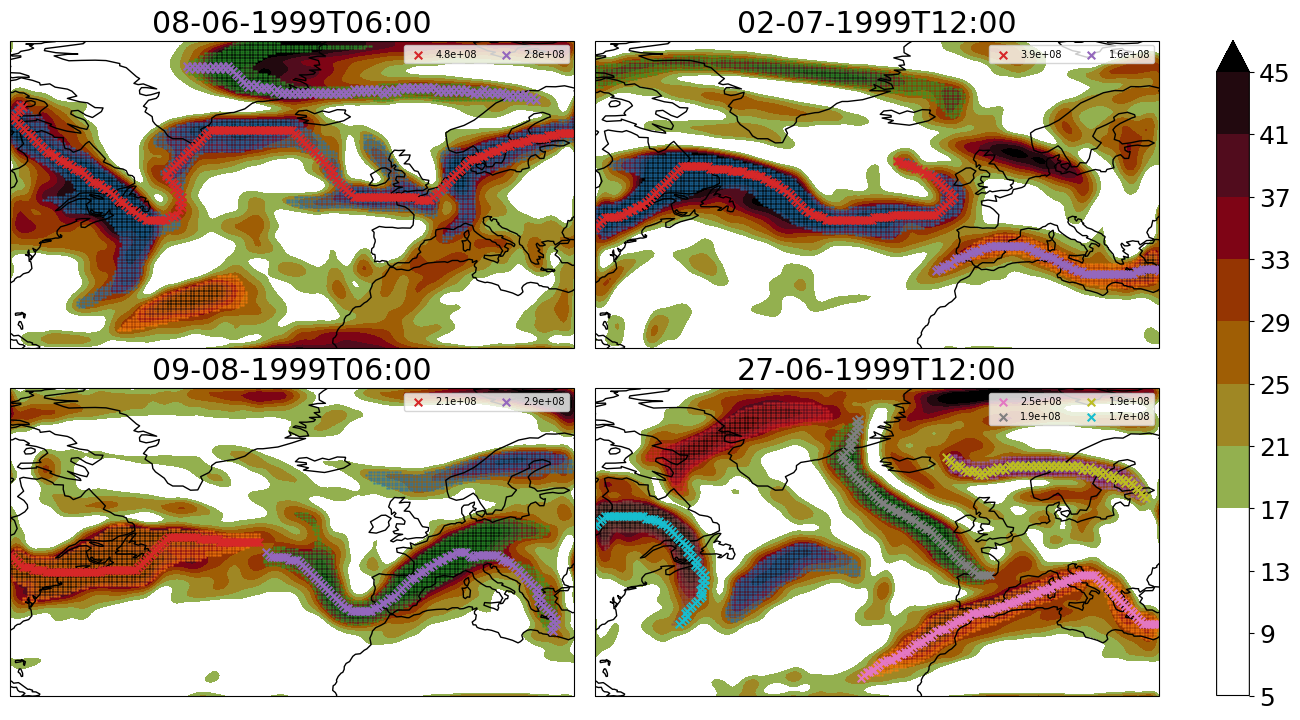

In [23]:
clu = Clusterplot(2, 2, get_region(ds))
its = np.random.randint(0, ds.time.shape[0], size=clu.nrow * clu.ncol)
norm = Normalize(.5, 4)
dss = []
for it in its:
    ds_ = ds.isel(time=it).copy()
    ds_ = preprocess(ds_, sigmas=range(3, 6))
    dss.append(ds_)
_ = clu.add_contourf([ds_["s_smooth"] for ds_ in dss], q=0.95, cmap=DEFAULT_COLORMAP, transparify=3, nlevels=11)
# _ = clu.add_contour([ds_["s_smo"] for ds_ in dss], nlevels=5)
for ds_, ax in tqdm(zip(dss, clu.axes.ravel()), total=len(dss)):
    groups, dist_mats = cluster_wind_speed(ds_, criterion_threshold=7.5, distance_function=pairwise_distances, min_size=500, distance_threshold=1.5)
    for group, dist_mat in zip(groups, dist_mats):
        ax.scatter(*group[["lon", "lat"]].to_numpy().T, s=1, alpha=0.5)
    jets = []
    for group, dist_mat in zip(groups, dist_mats):
        masked_weights = compute_weights(group, dist_mat)
        graph = create_graph(masked_weights, dist_mat)
        jet = find_jets_in_group_v2(graph, group, dist_mat, 1.3e8)
        if jet is not None:
            jets.append(jet)
    for jet in jets:
        ax.scatter(*jet[["lon", "lat"]].to_numpy().T, marker="x", s=30, label=f"{jet_integral_haversine(jet[['lon', 'lat', 's']].to_numpy()):.1e}", zorder=2)
    ax.set_title(ds_.time.dt.strftime("%d-%m-%YT%H:00").item())
    ax.legend(ncol=2, fontsize=7)
# plt.colorbar(im, ax=clu.axes)

# Extreme climatology

In [ ]:
sparse_exp = MultiVarExperiment("ERA5", "plev", ["s", "u", "v"], "6H", np.arange(1950, 2022, 5).tolist(), None, -80, 30, 20, 80, [200, 250, 300])

In [5]:
ds = sparse_exp.ds
# ds = flatten_by(ds, "s")

In [7]:
ds = preprocess(ds)

100%|██████████| 21916/21916 [06:13<00:00, 58.74it/s]


In [3]:
q = xr.open_dataarray(f"{DATADIR}/ERA5/plev/results/4/qs_crit.nc")
q_clim = compute_clim(q, "dayofyear")
q_clim = smooth(q_clim, {"dayofyear": ("win", 60)})
q_clim.to_netcdf(f"{DATADIR}/ERA5/plev/results/4/qs_clim.nc")

In [ ]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", (1940, 2022), None, -80, 30, 20, 80, [200, 250, 300])
qss = xr.open_dataarray(f"{DATADIR}/ERA5/plev/results/4/qs_crit.nc")

In [ ]:
all_jets, where_are_jets, all_jets_one_array = exp.find_jets(thresholds=qss[20, :], processes=10)

# Anim demo

In [2]:
def open_ds():
    ds = xr.Dataset()
    ds["u"] = open_da("ERA5", "plev", "u", "6H", 2000, [1, 2])[..., ::2, ::2].load()
    ds["v"] = open_da("ERA5", "plev", "v", "6H", 2000, [1, 2])[..., ::2, ::2].load()
    return ds

ds = open_ds()

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

In [3]:
bad_time = 11

In [4]:
jet_finder = JetFinder(
    preprocess=preprocess,
    cluster=cluster_criterion,
    refine_jets=jets_from_mask,
)

In [5]:
qss = xr.open_dataarray(f"{DATADIR}/ERA5/plev/results/4/qs_clim.nc")[20, :]

In [6]:
ds_ = ds.isel(time=44)

In [11]:
ds_ = preprocess(ds_)
groups, dist_mats = cluster_criterion(ds_, criterion_threshold=qss[11].values)


In [36]:
jets = jets_from_mask(groups, dist_mats)

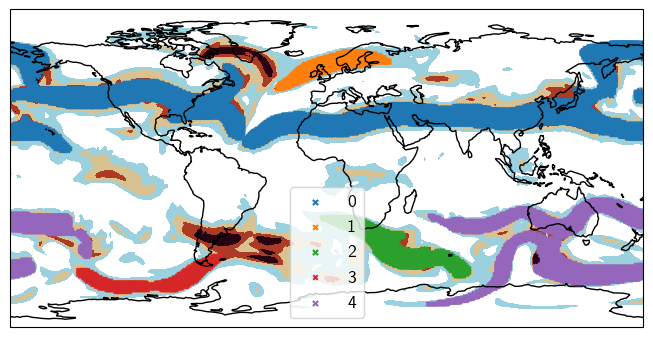

In [37]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds_["s"]], transparify=2, q=.90, nlevels=6, draw_cbar=False)
ax = clu.axes[0]
for i, jet in enumerate(groups):
    x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
    ax.scatter(x, y, s=s / 4, marker="x", alpha=1, label=i)
ax.legend()

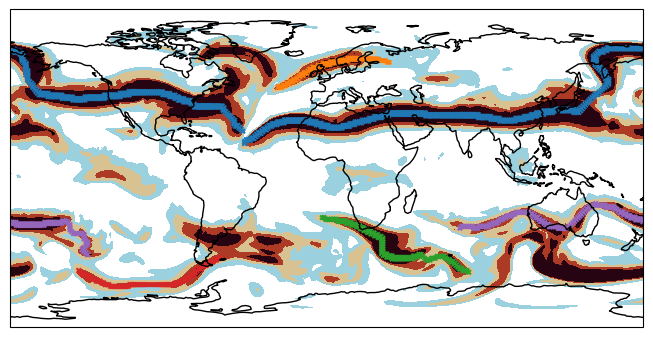

In [38]:
clu = Clusterplot(1, 1, get_region(ds))
clu.add_contourf([ds_["s"]], transparify=2, q=.90, nlevels=6, draw_cbar=False)
ax = clu.axes[0]
for i, jet in enumerate(jets):
    x, y, s = jet[["lon", "lat", "s"]].to_numpy().T
    ax.scatter(x, y, s=s / 4, marker="x", alpha=1)

In [17]:
jets = []
edges = None
for group, dist_mat in zip(groups, dist_mats):
    masked_weights = compute_weights(group, dist_mat)
    graph = create_graph(masked_weights, dist_mat)
    lon, lat, s = group[["lon", "lat", "s"]].to_numpy().T
    ux = np.unique(lon)
    if -180 in ux:
        starts, ends = determine_start_global(ux, lon, lat, masked_weights)
    else:
        starts, ends = determine_start_poly(lon, lat)
    starts, ends = adjust_edges(starts, ends, lon, edges)
    dmat_weighted, predecessors = shortest_path(
        graph, directed=True, return_predecessors=True, indices=starts
    )
    dmat_unweighted, _ = shortest_path(
        graph, unweighted=True, directed=True, return_predecessors=True, indices=starts
    )
    path = jets_from_many_predecessors(
        group[["lon", "lat", "s"]].to_numpy(),
        predecessors,
        ends,
        dmat_weighted,
        dmat_unweighted,
        8e7,
    )

In [24]:
diffx = np.diff(ux)
before = np.argwhere(lon == ux[-1]).flatten()
after = np.argwhere(lon == ux[0]).flatten()
newmask = masked_weights.mask.copy()
newmask[np.ix_(before, after)] = np.ones((len(before), len(after)), dtype=bool)
newmask[np.ix_(after, before)] = np.ones((len(after), len(before)), dtype=bool)
masked_weights_2 = np.ma.array(masked_weights.data, mask=newmask)
graph2 = csgraph_from_masked(masked_weights_2)
nco, labels = connected_components(graph2)

In [33]:
if len(ux) == (360 / dx):
    print("wow")

In [6]:
jets = jet_finder.call(ds, qss, processes=14)

100%|██████████| 240/240 [01:30<00:00,  2.66it/s]


MovieWriter ffmpeg unavailable; using Pillow instead.


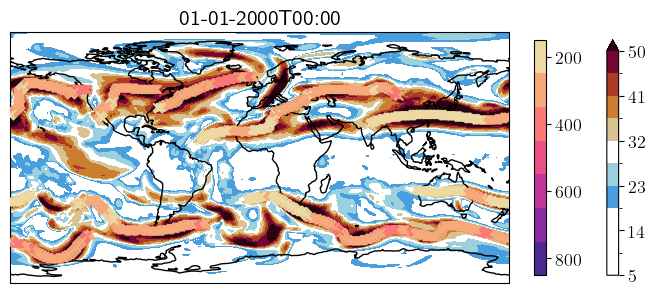

In [7]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(ds))
fig = clu.fig
ax = clu.axes[0]
times = ds.time
lon, lat = ds.lon.values, ds.lat.values
ds["s"] = np.sqrt(ds["u"] ** 2 + ds["v"] ** 2)
ds_flat = flatten_by(ds, "s")
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [ds_flat["s"].isel(time=0)], transparify=3, q=0.9, nlevels=11,
)
cs = ax.contourf(
    lon, lat, ds_flat["s"].isel(time=0).values, **kwargs_contourf
)
cmap_scatter = colormaps.agsunset_r
norm_scatter = Normalize(ds.lev.min(), ds.lev.max())
offsets = []
colors = []
for jet in jets[0]:
    offsets.append(jet[["lon", "lat"]])
    colors.append(jet["lev"])
pc = ax.scatter(*offsets[0].to_numpy().T, c=colors[0].tolist(), marker='x', norm=norm_scatter, cmap=cmap_scatter, zorder=100)
pc.set_offsets(np.concatenate(offsets))
pc.set_array(np.concatenate(colors))
cbar = fig.colorbar(cs, shrink=0.75)
cbar2 = fig.colorbar(pc, shrink=0.75)
cbar2.ax.invert_yaxis()

def animate(i):
    global pc
    global cs
    cs.remove()
    offsets = []
    colors = []
    for jet in jets[i]:
        offsets.append(jet[["lon", "lat"]])
        colors.append(jet["lev"])
    try:
        offsets = np.concatenate(offsets)
        colors = np.concatenate(colors)
    except ValueError:
        offsets = np.asarray([[0, 0]])
        colors = [0.5]
    pc.set_offsets(offsets)
    pc.set_array(colors)
    cs = ax.contourf(
        lon, lat, ds_flat["s"].isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime("%d-%m-%YT%H:00").item())
    return pc, cs


ani = FuncAnimation(fig, animate, frames=np.arange(0, len(times), 4))
ani.save("Figures/jet_anim.gif", dpi=150, fps=1)

# Anim track demo

In [ ]:
mask_202x = np.isin(DATERANGEPL_EXT_6H.year, [2020, 2021, 2022])
all_jets = load_pickle(ofile_aj)
all_jets = [all_jets[i] for i in np.where(mask_202x)[0]]
where_are_jets = np.load(ofile_waj)[mask_202x]
all_jets_one_array = np.load(ofile_ajoa)
ajot = np.load(ofile_ajot)
flags = np.load(ofile_flags)[mask_202x]

In [3]:
exp_wind = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", (2020, 2022), None, -80, 30, 20, 80, [200, 250, 300])
ds = exp_wind.ds

MovieWriter ffmpeg unavailable; using Pillow instead.


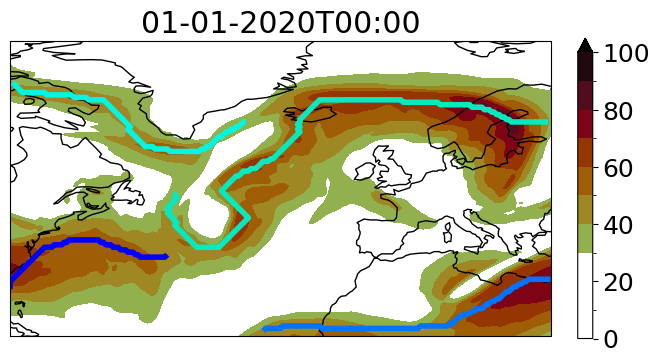

In [14]:
from matplotlib.collections import LineCollection, PathCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, get_region(ds))
fig = clu.fig
ax = clu.axes[0]
times = ds.time
lon, lat = ds.lon.values, ds.lat.values
ds_flat = flatten_by(ds, "s")
kwargs_contourf, _, _, _ = clu.setup_contourf(
    [ds_flat["s"].isel(time=0)], transparify=3, q=0.9, nlevels=11,
)
cs = ax.contourf(
    lon, lat, ds_flat["s"].isel(time=0).values, **kwargs_contourf
)
minflag = flags.min()
flags -= minflag
maxflag = np.amax(flags[flags < flags.max()])
nturns = 30
flag_colors = colormaps.BlAqGrYeOrReVi200(np.linspace(0, nturns, maxflag) % 1)
segments = []
colors = []
for j, jet in enumerate(all_jets[0]):
    segments.append(jet[["lon", "lat"]].to_numpy())
    colors.append(flag_colors[flags[0, j]])
lc = LineCollection(segments, colors=colors, lw=4)
ax.add_collection(lc)
cbar = fig.colorbar(cs)

def animate(i):
    global lc
    global cs
    for c in cs.collections:
        c.remove()
    segments = []
    colors = []
    for j, jet in enumerate(all_jets[i]):
        segments.append(jet[["lon", "lat"]].to_numpy())
        colors.append(flag_colors[flags[i, j]])
    lc.set_segments(segments)
    lc.set_colors(colors)
    cs = ax.contourf(
        lon, lat, ds_flat["s"].isel(time=i).values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime("%d-%m-%YT%H:00").item())
    return lc, cs


ani = FuncAnimation(fig, animate, frames=np.arange(0, 31 * 4))
ani.save("Figures/jet_anim_tracks.gif", dpi=150, fps=1)